In [1]:
!pip install datasets transformers
from datasets import load_dataset

In [2]:
hotpotqa = load_dataset("hotpot_qa", "distractor", split="train[:4%]", trust_remote_code=True)

hotpot_qa.py:   0%|          | 0.00/6.42k [00:00<?, ?B/s]

README.md:   0%|          | 0.00/9.19k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/90447 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/7405 [00:00<?, ? examples/s]

In [3]:
corpusset = load_dataset("BeIR/scidocs", 'corpus', trust_remote_code=True)["corpus"]
queryset = load_dataset("BeIR/scidocs", 'queries', trust_remote_code=True)["queries"]

qrels = load_dataset("BeIR/scidocs-qrels", trust_remote_code=True)["test"]

0000.parquet:   0%|          | 0.00/19.0M [00:00<?, ?B/s]

Generating corpus split:   0%|          | 0/25657 [00:00<?, ? examples/s]

queries/queries/0000.parquet:   0%|          | 0.00/93.3k [00:00<?, ?B/s]

Generating queries split:   0%|          | 0/1000 [00:00<?, ? examples/s]

README.md:   0%|          | 0.00/14.0k [00:00<?, ?B/s]

test.tsv:   0%|          | 0.00/2.54M [00:00<?, ?B/s]

Generating test split:   0%|          | 0/29928 [00:00<?, ? examples/s]

In [4]:
print (hotpotqa)
print (corpusset)
print (queryset)
print (qrels)

Dataset({
    features: ['id', 'question', 'answer', 'type', 'level', 'supporting_facts', 'context'],
    num_rows: 3618
})
Dataset({
    features: ['_id', 'title', 'text'],
    num_rows: 25657
})
Dataset({
    features: ['_id', 'title', 'text'],
    num_rows: 1000
})
Dataset({
    features: ['query-id', 'corpus-id', 'score'],
    num_rows: 29928
})


In [5]:
from tqdm import tqdm
import random

def get_random_negatives(golden_doc_titles, corpus, num_negatives):
    available_doc_titles = [doc_title for doc_title in corpus if doc_title not in golden_doc_titles]
    sampled_titles = random.sample(available_doc_titles, min(len(available_doc_titles), num_negatives))
    negatives = [''.join(corpus[doc_title]) for doc_title in sampled_titles]
    return negatives

def preprocess_train_data(data, num_negatives):
    corpus = {}
    for entry in data:
        for title, sentences in zip(entry['context']['title'], entry['context']['sentences']):
            if title not in corpus:
                corpus[title] = ''.join(sentences)

    processed_data = []

    for idx, entry in tqdm(enumerate(data), total=len(data)):
        query = entry['question']
        golden_doc_titles = entry['supporting_facts']['title']
        context = entry['context']
        
        for golden_doc_title in golden_doc_titles:
            golden_doc = ''.join(context['sentences'][context['title'].index(golden_doc_title)])
            negatives = get_random_negatives(golden_doc_titles, corpus, num_negatives)

            datapoint = {
                'query': query,
                'positives': [golden_doc],
                'negatives': negatives,
            }
            processed_data.append(datapoint)

    return processed_data

hotpotqa_train_data = preprocess_train_data(hotpotqa, 7)

100%|██████████| 3618/3618 [00:22<00:00, 157.46it/s]


In [6]:
from collections import defaultdict

def preprocess_test_data(corpus, queries, qrels):
    corpus_index = {row['_id']: row['text'] for row in corpus}
    queries_index = {row['_id']: row['text'] for row in queries}
    # print (queries_index)
    
    processed_data = {}

    for qrel in tqdm(qrels, total=len(qrels)):
        query_id = qrel['query-id']
        corpus_id = qrel['corpus-id']
        score = qrel['score']
        
        if query_id not in processed_data:
            processed_data[query_id] = {}
            processed_data[query_id]['query'] = queries_index[query_id]
            processed_data[query_id]['negatives'] = []
            processed_data[query_id]['positives'] = []

        if score == 0:
            processed_data[query_id]['negatives'].append(corpus_index[corpus_id])
        else:
            
            processed_data[query_id]['positives'].append(corpus_index[corpus_id])

    return list(processed_data.values())

scidocs_test_data = preprocess_test_data(corpusset, queryset, qrels)

100%|██████████| 29928/29928 [00:00<00:00, 38850.79it/s]


In [7]:
import torch
from torch import nn
from transformers import BertTokenizer, DataCollatorForLanguageModeling, BertModel, BertForMaskedLM

tokenizer = BertTokenizer.from_pretrained("bert-base-cased")

def tokenize_input(query, document):
    return tokenizer.encode_plus(
        query,
        document,
        add_special_tokens=True,
        max_length=512,
        padding='max_length',
        truncation=True,
        return_tensors="pt"
    )

data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=True,
    mlm_probability=0.15,
    return_tensors="pt"
)

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [8]:
from torch.utils.data import Dataset, DataLoader

def collate_fn(batch):
    return batch[0]

class TokenizedDataset(Dataset):
    def __init__(self, data_list, tokenizer_function, data_collator, device):
        self.data = []
        for data in tqdm(data_list, total=len(data_list)):
            query = data['query']
            positives = data['positives']
            negatives = data['negatives']

            encoding_poses = [tokenizer_function(query, pos).to(device) for pos in positives]
            encoding_negs = [tokenizer_function(query, neg).to(device) for neg in negatives]
            
            all_input_ids = torch.cat([encoding_pos['input_ids'] for encoding_pos in encoding_poses] + [encoding_neg['input_ids'] for encoding_neg in encoding_negs], dim=0)
            all_attention_masks = torch.cat([encoding_pos['attention_mask'] for encoding_pos in encoding_poses] + [encoding_neg['attention_mask'] for encoding_neg in encoding_negs], dim=0)
            
            if data_collator is not None:                
                batch = [{'input_ids': input_id, 'attention_mask': attention_mask} for input_id, attention_mask in zip(all_input_ids, all_attention_masks)]
                masked_batch = data_collator(batch)
                masked_input_ids = masked_batch['input_ids'].to(device)
                masked_attention_mask = masked_batch['attention_mask'].to(device)
                
                self.data.append((all_input_ids, all_attention_masks, masked_input_ids, masked_attention_mask, len(positives), len(negatives)))
            else:
                self.data.append((all_input_ids, all_attention_masks, len(positives), len(negatives)))
                
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [9]:
import warnings
import logging
warnings.filterwarnings('ignore')
logging.getLogger("transformers").setLevel(logging.ERROR)

In [10]:
hotpotqa_train_dataloader = DataLoader(TokenizedDataset(hotpotqa_train_data, tokenize_input, None, 'cuda'), collate_fn=collate_fn)

100%|██████████| 8700/8700 [02:27<00:00, 58.96it/s]


In [11]:
scidocs_test_dataloader = DataLoader(TokenizedDataset(scidocs_test_data, tokenize_input, data_collator, 'cuda'), collate_fn=collate_fn)

100%|██████████| 1000/1000 [01:55<00:00,  8.63it/s]


In [12]:
class ModifiedBertModel(nn.Module):
    def __init__(self, bert_model_name="bert-base-cased", dropout_prob=0.1):
        super(ModifiedBertModel, self).__init__()

        self.bertmlm = BertForMaskedLM.from_pretrained(bert_model_name)
        self.freeze_bert()
        self.ffl = nn.Sequential(
            nn.Linear(self.bertmlm.config.hidden_size, self.bertmlm.config.hidden_size),
            nn.ReLU(),  # Activation function
            nn.Dropout(dropout_prob),
            nn.Linear(self.bertmlm.config.hidden_size, 1)  # Output layer
        )

    def freeze_bert(self):
        for param in self.bertmlm.bert.embeddings.parameters():
            param.requires_grad = False
        for layer in self.bertmlm.bert.encoder.layer:
            for param in layer.parameters():
                param.requires_grad = False

    def unfreeze_bert(self):
        for param in self.bertmlm.bert.embeddings.parameters():
            param.requires_grad = True
        for layer in self.bertmlm.bert.encoder.layer:
            for param in layer.parameters():
                param.requires_grad = True
    
    def forward(self, input_ids, attention_mask):
        outputs = self.bertmlm(input_ids=input_ids, attention_mask=attention_mask, output_hidden_states=True)
        cls_output = outputs.hidden_states[-1][:, 0, :]

        ffl_output = self.ffl(cls_output)
        return ffl_output.squeeze(dim=1)

    def reconstruct(self, input_ids, attention_mask, masked_input_ids, masked_attention_masks):
        labels = input_ids.clone()
        labels[input_ids != masked_input_ids] = -100
        
        outputs = self.bertmlm(input_ids=masked_input_ids, attention_mask=masked_attention_masks, labels=labels)
        return outputs

In [13]:
from torch.nn import CrossEntropyLoss

CELoss = CrossEntropyLoss()

def train_ffl(dataloader, model, optimizer, epochs=3, device='cuda'):
    model.to(device)
    model.freeze_bert()
    model.train()
    total_queries = len(dataloader)

    for epoch in range(epochs):
        total_loss = 0

        for all_input_ids, all_attention_masks, num_positive, num_negative in tqdm(dataloader, desc=f"Epoch {epoch+1}", total=total_queries):
            predictions = model(all_input_ids, all_attention_masks)
            target = torch.cat([torch.ones(num_positive), torch.zeros(num_negative)], dim=0).to(device)
            
            loss = CELoss(predictions, target)
 
            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / total_queries
        print(f'Epoch {epoch+1}, Average Loss: {avg_loss}')

In [14]:
def inference_basecase(dataloader, model, device='cuda'):
    model.to(device)
    model.eval()    

    precision_at_10 = 0
    recall_at_10 = 0
    mrr_total = 0
    total_queries = len(dataloader)
    
    with torch.no_grad():
        for all_input_ids, all_attention_masks, _, _, num_positive, num_negative in tqdm(dataloader, desc="Zero Shot Inference on SciDocs", total=total_queries):
            predictions = model(all_input_ids, all_attention_masks)

            rankings = torch.argsort(torch.argsort(predictions, descending=True))
            rank_of_positives = rankings[:num_positive]
            
            precision_at_10 += len(list(filter(lambda x: x < 10, rank_of_positives))) / min(len(predictions), 10)
            recall_at_10 += len(list(filter(lambda x: x < 10, rank_of_positives))) / num_positive

            rank_of_first_positive = min(rank_of_positives).item() + 1
            mrr_total += 1 / rank_of_first_positive
    
    precision_at_10 /= total_queries
    recall_at_10 /= total_queries
    mrr_total /= total_queries
    
    print(f'Precision@10: {precision_at_10}')
    print(f'Recall@10: {recall_at_10}')
    print(f'MRR: {mrr_total}')
    
    return precision_at_10, recall_at_10, mrr_total

In [15]:
import copy

def inference_modified(dataloader, model, optimizer, K=1, device='cuda'):
    model.to(device)

    model_original = copy.deepcopy(model.state_dict())

    precision_at_10 = 0
    recall_at_10 = 0
    mrr_total = 0
    total_queries = len(dataloader)

    restore_counter = 0
    
    for all_input_ids, all_attention_masks, masked_input_ids, masked_attention_masks, num_positive, num_negative in tqdm(dataloader, desc=f"Zero Shot Modified (K={K}) Inference on SciDocs", total=total_queries):
        predictions = []
        for idx in range(len(all_input_ids)):
            model.train()
            model.unfreeze_bert()
            
            outputs = model.reconstruct(all_input_ids[idx].unsqueeze(0), all_attention_masks[idx].unsqueeze(0), masked_input_ids[idx].unsqueeze(0), masked_attention_masks[idx].unsqueeze(0))
            loss = outputs.loss
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            model.eval()
            with torch.no_grad():
                predictions.append(model(all_input_ids[idx].unsqueeze(0), all_attention_masks[idx].unsqueeze(0)))

            restore_counter += 1
            if restore_counter == K:
                model.load_state_dict(model_original)
                restore_counter = 0
                
        predictions = torch.tensor(predictions)
        rankings = torch.argsort(torch.argsort(predictions, descending=True))
        rank_of_positives = rankings[:num_positive]
        
        precision_at_10 += len(list(filter(lambda x: x < 10, rank_of_positives))) / min(len(predictions), 10)
        recall_at_10 += len(list(filter(lambda x: x < 10, rank_of_positives))) / num_positive

        rank_of_first_positive = min(rank_of_positives).item() + 1
        mrr_total += 1 / rank_of_first_positive

    
    precision_at_10 /= total_queries
    recall_at_10 /= total_queries
    mrr_total /= total_queries
    
    print(f'Precision@10: {precision_at_10}')
    print(f'Recall@10: {recall_at_10}')
    print(f'MRR: {mrr_total}')
    
    return precision_at_10, recall_at_10, mrr_total

In [16]:
model = ModifiedBertModel()
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

In [17]:
train_ffl(hotpotqa_train_dataloader, model, optimizer)

Epoch 1: 100%|██████████| 8700/8700 [48:30<00:00,  2.99it/s]


Epoch 1, Average Loss: 1.6507475274313113


Epoch 2: 100%|██████████| 8700/8700 [48:33<00:00,  2.99it/s]


Epoch 2, Average Loss: 1.4283346206866654


Epoch 3: 100%|██████████| 8700/8700 [48:30<00:00,  2.99it/s]

Epoch 3, Average Loss: 1.376682844408761


In [18]:
precision_base, recall_base, mrr_base = inference_basecase(scidocs_test_dataloader, model)

Zero Shot Inference on SciDocs: 100%|██████████| 1000/1000 [20:24<00:00,  1.22s/it]

Precision@10: 0.21979999999999952
Recall@10: 0.4461499999999993
MRR: 0.4904556215842975


In [19]:
K_values = [1, 8, 16, 64]
precision_values = []
recall_values = []
mrr_values = []

for K in K_values:
    p, r, m = inference_modified(scidocs_test_dataloader, model, optimizer, K)
    precision_values.append(p)
    recall_values.append(r)
    mrr_values.append(m)

Zero Shot Modified (K=1) Inference on SciDocs: 100%|██████████| 1000/1000 [1:50:55<00:00,  6.66s/it]


Precision@10: 0.24090000000000011
Recall@10: 0.4894333333333336
MRR: 0.514902083923987


Zero Shot Modified (K=8) Inference on SciDocs: 100%|██████████| 1000/1000 [1:48:34<00:00,  6.51s/it]


Precision@10: 0.195899999999999
Recall@10: 0.39878333333333144
MRR: 0.4459262353360948


Zero Shot Modified (K=16) Inference on SciDocs: 100%|██████████| 1000/1000 [1:48:27<00:00,  6.51s/it]


Precision@10: 0.16949999999999987
Recall@10: 0.3445333333333332
MRR: 0.276748372581487


Zero Shot Modified (K=64) Inference on SciDocs: 100%|██████████| 1000/1000 [1:48:17<00:00,  6.50s/it]

Precision@10: 0.1958999999999997
Recall@10: 0.39954999999999946
MRR: 0.420168676001799


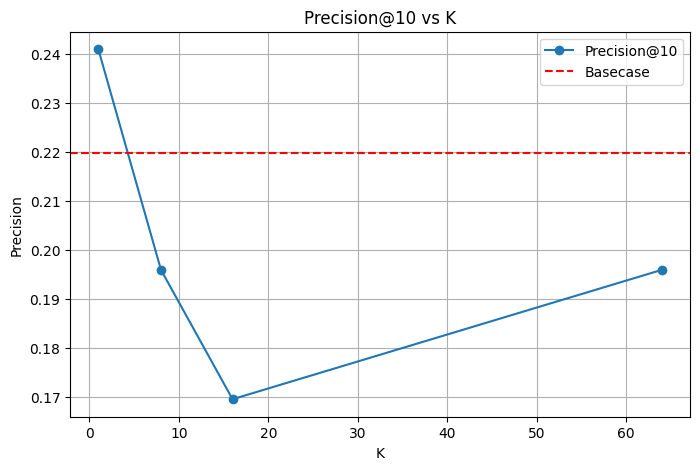

In [20]:
import matplotlib.pyplot as plt

# Precision@10 graph
plt.figure(figsize=(8, 5))
plt.plot(K_values, precision_values, marker='o', label='Precision@10')
plt.axhline(precision_base, color='r', linestyle='--', label='Basecase')
plt.title("Precision@10 vs K")
plt.xlabel("K")
plt.ylabel("Precision")
plt.legend()
plt.grid(True)
plt.show()

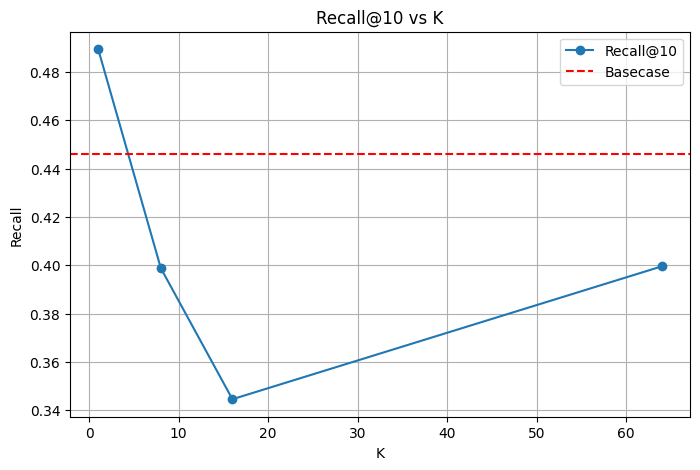

In [21]:
# Recall@10 graph
plt.figure(figsize=(8, 5))
plt.plot(K_values, recall_values, marker='o', label='Recall@10')
plt.axhline(recall_base, color='r', linestyle='--', label='Basecase')
plt.title("Recall@10 vs K")
plt.xlabel("K")
plt.ylabel("Recall")
plt.legend()
plt.grid(True)
plt.show()

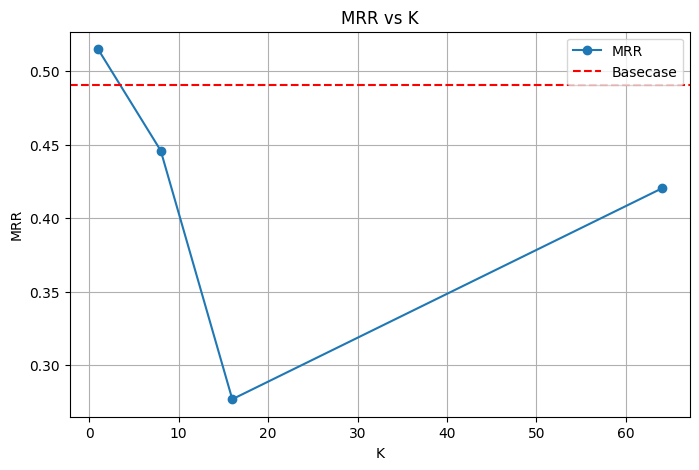

In [22]:
# MRR graph
plt.figure(figsize=(8, 5))
plt.plot(K_values, mrr_values, marker='o', label='MRR')
plt.axhline(mrr_base, color='r', linestyle='--', label='Basecase')
plt.title("MRR vs K")
plt.xlabel("K")
plt.ylabel("MRR")
plt.legend()
plt.grid(True)
plt.show()